# <b>1 Author</b> : 
### <b>Student Name</b> : Nitish Krishna Sadhu
### <b>Student ID</b>   : 220283937

In [1]:
# importing necessary packages
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import IPython.display as ipd
from tqdm import tqdm
import librosa

import os, sys, re, pickle, glob
import urllib.request
import zipfile

from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics import precision_recall_fscore_support

# <b>2 Problem</b> 
## Using the MLEnd London Sounds dataset, build a machine learning pipeline that takes as an input an audio segment and predicts the <i>area</i> where the audio segment has been recorded.

In [2]:
# mounting the drive where the data lies
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# import the paths of the audio files for training 
path_train = '/content/drive/MyDrive/Data/MLEndLS/MLEnd_data/MLEndLS_train/*.wav'
files_train = glob.glob(path_train)

In [4]:
# import the paths of the audio files for validation 
path_val = '/content/drive/MyDrive/Data/MLEndLS/MLEnd_data/MLEndLS_val/*.wav'
files_val = glob.glob(path_val)

In [5]:
# reading the csv file MLEndLS.csv
MLENDLS_df = pd.read_csv('./MLEndLS.csv').set_index('file_id') 
MLENDLS_df.head()

,area,spot,in_out,Participant
file_id,,,,
0001.wav,british,street,outdoor,S151
0002.wav,kensington,dinosaur,indoor,S127
0003.wav,campus,square,outdoor,S18
0004.wav,kensington,hintze,indoor,S179
0005.wav,campus,square,outdoor,S176


In [6]:
# Creating MLENDLS_df_train from MLENDLS_df dataframe
MLENDLS_df_train = pd.concat([MLENDLS_df[0:1000], MLENDLS_df[1500:]])
display(MLENDLS_df_train.head())

# Creating MLENDLS_df_val from MLENDLS_df dataframe
MLENDLS_df_val = MLENDLS_df[1000:1500]
display(MLENDLS_df_val.head())

,area,spot,in_out,Participant
file_id,,,,
0001.wav,british,street,outdoor,S151
0002.wav,kensington,dinosaur,indoor,S127
0003.wav,campus,square,outdoor,S18
0004.wav,kensington,hintze,indoor,S179
0005.wav,campus,square,outdoor,S176


,area,spot,in_out,Participant
file_id,,,,
1001.wav,Euston,library,indoor,S142
1002.wav,Euston,piazza,outdoor,S4
1003.wav,westend,piazza,outdoor,S179
1004.wav,campus,library,outdoor,S147
1005.wav,westend,charing,indoor,S155


# <b>3 Machine Learning pipeline</b>

### <b>Pipeline</b> to classify an audio file:

  <i>file_path</i> ------> <b>classify_audio</b> ------> <i>prediction</i>

  The function <b><i>classify_audio</i></b> takes the path to the location where the file exists and outputs the prediction.

  <b>classify_audio:</b><br>
      <i>file_path</i> ------> <b>getParam</b> ---<i>X</i>---> <b>pca transform</b> ---<i>X_pca</i>---> <b>model.predict</b> ------> <i>Prediction</i>

  Inside the <b><i>classify_audio</i></b> function, the file_path is passed into the getparam function to get the features to predict the audio. The dimensionality of the predictors is reduced by performing the principle component analysis which helped in improving the accuracy. These reduced features are then used to make the classification.

  


In [7]:
# Function to get predictors(X) and labels(y)
def getXy(files,labels_file, scale_audio=False, onlySingleDigit=False, mfcc=False):
  X,y =[],[]

  if not mfcc:
    for file in tqdm(files):
      try:
        fileID = file.split('/')[-1]
        file_name = file.split('/')[-1]
        yi = labels_file.loc[fileID]['area']

        fs = None
        x, fs = librosa.load(file,sr=fs)
        if scale_audio: x = x/np.max(np.abs(x))
        f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      
        power = np.sum(x**2)/len(x)
        pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
        pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
        voiced_fr = np.mean(voiced_flag)

        xi = [power,pitch_mean,pitch_std,voiced_fr]
        X.append(xi)
        y.append(yi)

      except:
        files.remove(file)
        labels_file.drop(file.split('/')[-1])

    return np.array(X),np.array(y)

  if mfcc:
    for file in tqdm(files):
      try:
        fileID = file.split('/')[-1]
        file_name = file.split('/')[-1]
        yi = labels_file.loc[fileID]['area']

        fs = None
        x, fs = librosa.load(file,sr=fs)
        xi = librosa.feature.mfcc(y=x, sr=fs)

        temp_arr = []
        for arr in xi:
            temp_arr.append(np.mean(arr))

        
        X.append(np.array(temp_arr))
        y.append(yi)

      except:
        files.remove(file)
        labels_file.drop(file.split('/')[-1])

    return np.array(X),np.array(y)

In [8]:
# Function to get predictors(X) of a single audio file
def getParam(file, scale_audio=False, onlySingleDigit=False, mfcc=False):
    
    # code for the features power, pitch_mean, pitch_std, voiced_fr 
    if not mfcc:
      try:
        X =[]

        fs = None
        x, fs = librosa.load(file,sr=fs)
        if scale_audio: x = x/np.max(np.abs(x))
        f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      
        power = np.sum(x**2)/len(x)
        pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
        pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
        voiced_fr = np.mean(voiced_flag)

        xi = [power,pitch_mean,pitch_std,voiced_fr]
        X.append(xi)

      except:
        print('Corrupt audio file')

      return np.array(X)

    # code for MFCCs
    if mfcc:
      try:
        X =[]

        fs = None
        x, fs = librosa.load(file,sr=fs)
        xi = librosa.feature.mfcc(y=x, sr=fs)

        temp_arr = []
        for arr in xi:
            temp_arr.append(np.mean(arr))

        
        X.append(np.array(temp_arr))

      except:
        print('Corrupt audio file')

      return np.array(X)

In [9]:
# Function to get pitch of an audio file
def getPitch(x,fs,winLen=0.02):
  winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

# <b>4 Transformation stage</b>
The audio file to be predictied is passed into getParam to extract the features.<br><br>
In the getParam function, the Mel-frequency cepstrum Co-efficients are extracted.<br><br>
Every audio file gets a two dimensional array as the MFCCs. In order to reduce it to an one dimensional array we take mean across the rows. We do this to be consistent across every audio file that needs to be predicted.<br><br>
By using the Principle Component Analysis, we reduce the number of features used to classify the audio. As having two many features might lead to overfitting while training and also to reduce the training time.<br><br>
I chose MFCCs over [power, pitch_mean, pitch_std, voiced_fr] as MFCCs can be obtained a lot quicker which improves training speed.I have also observed MFCCs combined with PCA improving the accuracy of the model.


In [10]:
# function for principle components
def pca(X,n=2):

  pca = PCA(n_components=n)
  return pca.fit(X)

In [11]:
X_train_mfcc,y_train_mfcc = getXy(files_train, labels_file=MLENDLS_df_train, scale_audio=True, onlySingleDigit=True, mfcc=True)

100%|██████████| 2000/2000 [03:13<00:00, 10.35it/s]


In [12]:
X_val_mfcc,y_val_mfcc = getXy(files_val, labels_file=MLENDLS_df_val, scale_audio=True, onlySingleDigit=True, mfcc=True)

100%|██████████| 500/500 [06:33<00:00,  1.27it/s]


In [13]:
X_train,y_train = getXy(files_train, labels_file=MLENDLS_df_train, scale_audio=True, onlySingleDigit=True, mfcc=False)

 35%|███▌      | 704/2000 [13:29<24:13,  1.12s/it]<ipython-input-7-fa45dee9788e>:14: RuntimeWarning: invalid value encountered in true_divide
  if scale_audio: x = x/np.max(np.abs(x))
100%|█████████▉| 1998/2000 [38:07<00:02,  1.14s/it]


In [14]:
X_val,y_val = getXy(files_val, labels_file=MLENDLS_df_val, scale_audio=True, onlySingleDigit=True, mfcc=False)

100%|██████████| 500/500 [09:24<00:00,  1.13s/it]


# <b>5 Modelling</b>



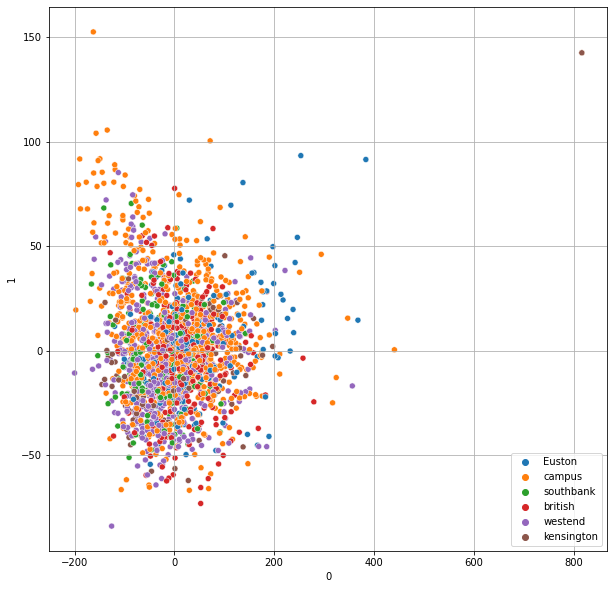

In [15]:
# visualising the data
toPCA = PCA(n_components=2)
toPCA.fit(X_train_mfcc)
train_df = pd.DataFrame(toPCA.transform(X_train_mfcc))
train_df['label'] = y_train_mfcc # temporary dataframe for plotting

fig, ax = plt.subplots(figsize = [10,10])
sns.scatterplot(data = train_df, x = train_df[0], y = train_df[1], hue = train_df['label'], ax = ax)

plt.legend()
plt.grid()

plt.show()

#### As we can see in the above plot, it is not obvious which model to use.<br>
#### So I have tested three models(SVC, knn, GaussianNB) and picked the one with the best metrics. 

In [42]:
# function to train a model
def train_model(X, y, knn = False, gnb = False, svc = True, neighbours = 6):
  '''
      This function trains a model

      X     : array
        Predictors
      y     : array
        labels
      knn   : Boolean
        default : False
      gnb   : Boolean
        default : False
      svc   : Boolean
        default : True 

      return: model
  '''
  if knn:
    knn = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=neighbours, algorithm='auto', weights = 'distance'))
    model = knn.fit(X, y)
    yPred = model.predict(X)
    
    return model

  if gnb:
    gnb = make_pipeline(StandardScaler(), GaussianNB(var_smoothing=1e-9))
    model = gnb.fit(X, y)
    yPred = model.predict(X)
    
    return model

  if svc:
    clf = make_pipeline(StandardScaler(), svm.SVC(gamma=9))
    model = clf.fit(X, y)
    yPred = model.predict(X)
    
    return model

In [38]:
# function to validate a trained model
def validate_model(model, X, y):
  '''
      This function validates a trained model. Prints validation accuracy

      model : 
        model that needs validation
      X     : array
        Predictors
      y     : array
        labels

      return: None
  '''
  yPred = model.predict(X)
  precision, recall, f_score, support = precision_recall_fscore_support(y, yPred)
  print('Validation accuracy: ',np.mean(yPred == y))
  print('Precision: ', np.mean(precision))
  print('Recall: ', np.mean(recall))
  print('F_Score: ', np.mean(f_score))
  return None

# <b>6 Methodology</b>

The function train_model is used to train a model.The function takes an array/dataframe of features and a numpy array of labels as input and outputs a knn model object as the output.<br>
I have used 2000 out of 2500 audio files for training and the remaining 500 audio files for validation.<br>
Increasing the number of files used for training from 500 to 2000 have only improved the accuracy by only a small amount.<br>
The metrics of accuracy, precision, recall and f-score are used to evaluate the model.

# <b> 7 Dataset</b>

I have extracted MFCCs of all the training and validation datasets to train and validate the data. 
Preprocessing invloved the calculation of mean across the rows of the MFCC of the audio files and reducing the dimensionality through PCA.

In [39]:
# Applying princliple components analysis to X_train
to_pca = pca(X_train_mfcc,9)
X_train_mfcc_pca = to_pca.transform(X_train_mfcc)

# Applying princliple components analysis to X_val
X_val_mfcc_pca = to_pca.transform(X_val_mfcc)

#<b>8 Results</b>

In [40]:
# Training models
model_svc = train_model(X_train, y_train, knn = False, gnb = False, svc = True)
model_knn = train_model(X_train, y_train, knn = True, gnb = False, svc = False)
model_gnb = train_model(X_train, y_train, knn = False, gnb = True, svc = False)

# Validating the model

validate_model(model_svc, X_val, y_val)
print('-----xxxx-----')
validate_model(model_knn, X_val, y_val)
print('-----xxxx-----')
validate_model(model_gnb, X_val, y_val)

Validation accuracy:  0.338
Precision:  0.321797294224381
Recall:  0.2079833121322483
F_Score:  0.18061318069161894
-----xxxx-----
Validation accuracy:  0.34
Precision:  0.26247552435916377
Recall:  0.23339934712275137
F_Score:  0.2267074371412666
-----xxxx-----
Validation accuracy:  0.338
Precision:  0.12834300671446455
Recall:  0.19249568717653823
F_Score:  0.13551995931858632


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [53]:
# Training models
model_mfcc_svc = train_model(X_train_mfcc_pca, y_train_mfcc, knn = False, gnb = False, svc = True)
model_mfcc_knn = train_model(X_train_mfcc_pca, y_train_mfcc, knn = True, gnb = False, svc = False, neighbours=14)
model_mfcc_gnb = train_model(X_train_mfcc_pca, y_train_mfcc, knn = False, gnb = True, svc = False)

# Validating the model
print('svc: ')
validate_model(model_mfcc_svc, X_val_mfcc_pca, y_val_mfcc)
print('-----xxxx-----')
print('knn: ')
validate_model(model_mfcc_knn, X_val_mfcc_pca, y_val_mfcc)
print('-----xxxx-----')
print('gnb')
validate_model(model_mfcc_gnb, X_val_mfcc_pca, y_val_mfcc)

svc: 
Validation accuracy:  0.296
Precision:  0.04933333333333333
Recall:  0.16666666666666666
F_Score:  0.07613168724279835
-----xxxx-----
knn: 
Validation accuracy:  0.408
Precision:  0.41005281927094045
Recall:  0.32119673035192436
F_Score:  0.3352667361607864
-----xxxx-----
gnb
Validation accuracy:  0.394
Precision:  0.30478275140026684
Recall:  0.27304426909558327
F_Score:  0.26753154151363495


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Comparing the accuracies of the models when using mfcc vs when using [power,pitch_mean,pitch_std,voiced_fr], we get better accuracy when using mfcc<br>
#### Among the three models, we get the best results with the knn model.

In [44]:
# Function to calculate the ideal number of components for the best accuracy
def ideal_pca(X, y, XVal, yVal, knn = False, gnb = False, svc = True):
  train_acc = []
  val_acc = []
  for i in tqdm(range(1,20)):
    to_pca = pca(X,i)
    X_pca_train = to_pca.transform(X)
    X_pca_val = to_pca.transform(XVal)
    
    model = train_model(X_pca_train, y, knn = knn, gnb = gnb, svc = svc)
    yPred_train = model.predict(X_pca_train)
    yPred_val = model.predict(X_pca_val)

    train_acc.append(np.mean(yPred_train == y))
    val_acc.append(np.mean(yPred_val == yVal))

  return train_acc, val_acc

In [45]:
train_acc_knn, val_acc_knn = ideal_pca(X_train_mfcc, y_train_mfcc, X_val_mfcc, y_val_mfcc, knn = True, gnb = False, svc = False)
train_acc_gnb, val_acc_gnb = ideal_pca(X_train_mfcc, y_train_mfcc, X_val_mfcc, y_val_mfcc, knn = False, gnb = True, svc = False)
train_acc_svc, val_acc_svc = ideal_pca(X_train_mfcc, y_train_mfcc, X_val_mfcc, y_val_mfcc, knn = False, gnb = False, svc = True)

100%|██████████| 19/19 [00:20<00:00,  1.06s/it]


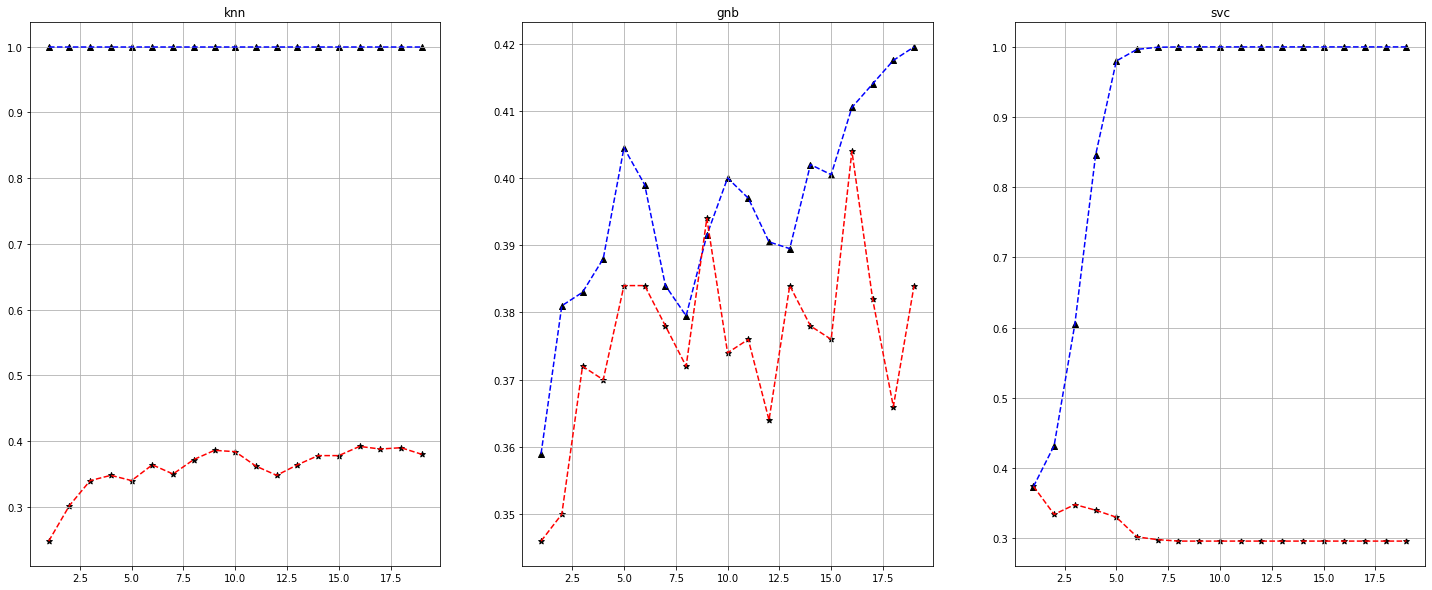

In [46]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[25,10])

ax1.scatter(np.arange(1,20),train_acc_knn, marker='^', color='black')
ax1.plot(np.arange(1,20), train_acc_knn, linestyle='--', color='blue')
ax1.scatter(np.arange(1,20),val_acc_knn, marker='*', color='black')
ax1.plot(np.arange(1,20), val_acc_knn, linestyle='--', color='red')
ax1.set_title('knn')
ax1.grid()

ax2.scatter(np.arange(1,20),train_acc_gnb, marker='^', color='black')
ax2.plot(np.arange(1,20), train_acc_gnb, linestyle='--', color='blue')
ax2.scatter(np.arange(1,20),val_acc_gnb, marker='*', color='black')
ax2.plot(np.arange(1,20), val_acc_gnb, linestyle='--', color='red')
ax2.set_title('gnb')
ax2.grid()

ax3.scatter(np.arange(1,20),train_acc_svc, marker='^', color='black')
ax3.plot(np.arange(1,20), train_acc_svc, linestyle='--', color='blue')
ax3.scatter(np.arange(1,20),val_acc_svc, marker='*', color='black')
ax3.plot(np.arange(1,20), val_acc_svc, linestyle='--', color='red')
ax3.set_title('svc')
ax3.grid()

plt.show()

From the above plots, knn yields the best training and validation accuracy. Looking at the knn's plot we can see at number of components for pca = 9, we can obtain the best validation accuracy(We can obtain even better accuracy at n=16, but that might overfit because of the high dimensions)

In [47]:
def ideal_neighbours(X, y, Xval, yval):
  train_acc = []
  val_acc = []
  for i in range(1,20):
    model = train_model(X, y, knn = True, gnb = False, svc = False, neighbours = i)

    y_pred_train = model.predict(X)
    y_pred_val = model.predict(Xval)

    train_acc.append(np.mean(y_pred_train == y))
    val_acc.append(np.mean(y_pred_val == yval))

  fig, ax1 = plt.subplots(figsize=[25,10])

  ax1.scatter(np.arange(1,20),train_acc, marker='^', color='black')
  ax1.plot(np.arange(1,20), train_acc, linestyle='--', color='blue')
  ax1.scatter(np.arange(1,20),val_acc, marker='*', color='black')
  ax1.plot(np.arange(1,20), val_acc, linestyle='--', color='red')
  ax1.set_title('knn')
  ax1.grid()

  plt.show()

  return train_acc, val_acc


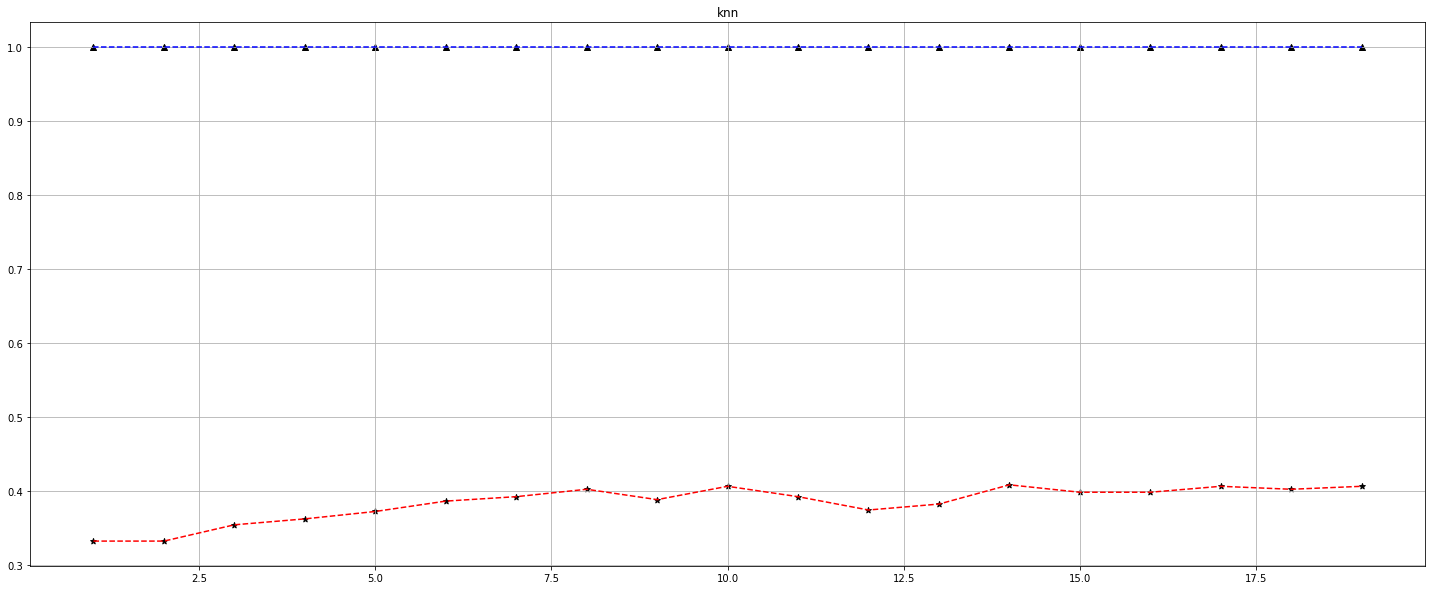

In [51]:
acc_train, acc_val = ideal_neighbours(X_train_mfcc_pca, y_train_mfcc, X_val_mfcc_pca, y_val_mfcc)

In [54]:
print(acc_train)
print(acc_val)

[0.9995, 0.9995, 0.9995, 0.9995, 0.9995, 0.9995, 0.9995, 0.9995, 0.9995, 0.9995, 0.9995, 0.9995, 0.9995, 0.9995, 0.9995, 0.9995, 0.9995, 0.9995, 0.9995]
[0.332, 0.332, 0.354, 0.362, 0.372, 0.386, 0.392, 0.402, 0.388, 0.406, 0.392, 0.374, 0.382, 0.408, 0.398, 0.398, 0.406, 0.402, 0.406]


From the above plot we can see that we get the highest validation accuracy at neighbours = 19, but having number of neigbours so high might lead to over fitting. Instead lets chose neighbours = 13

In [55]:
# function to classify a single audio file
def classify_audio(file_path):
    '''
        This function classifies an audio file.

        file_path : String
          path to the location of the file

        return : String
          a string of the predicted label 
    '''
    
    X = getParam(file_path, scale_audio=True, onlySingleDigit=True, mfcc = True)
    X_pca = to_pca.transform(X)
    yPred = model_mfcc_knn.predict(X_pca)

    return yPred[0]

In [56]:
# function to classify a list of audio files
def classify_list(path):
  '''
      This function classifies a list of audio files.

      path : String
        path to the location of the files

      return : numpy array
        an array of the predicted labels
  '''
  x = []
  files = glob.glob(path)
  for i in tqdm(range(0, len(files))):
    x.append(getParam(files[i], scale_audio=True, onlySingleDigit=True, mfcc=True)[0])

  x_pca = to_pca.transform(x)
  yPred = model_mfcc_knn.predict(x_pca)
  
  return yPred

#### Please use the function <i><b>classify_audio</b></i> to classify an audio file. Example given below

In [57]:
classify_audio('/content/drive/MyDrive/Data/MLEndLS/MLEnd_data/MLEndLS_train/0007.wav')

'Euston'

#### Please use the function <i><b>classify_list</b></i> to classify a list of audio files. Example given below

In [58]:
yPred = classify_list('/content/drive/MyDrive/Data/MLEndLS/MLEnd_data/MLEndLS_val/*.wav')

100%|██████████| 500/500 [00:27<00:00, 18.22it/s]


# <b>9 Conclusions</b>

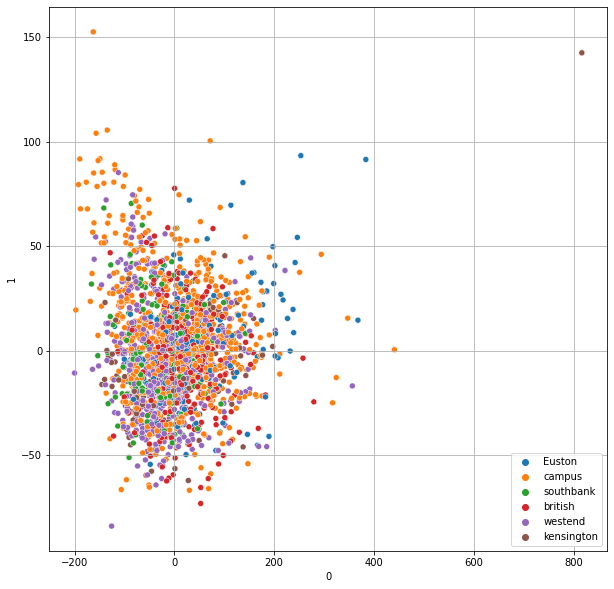

In [ ]:
# visualising the data
train_df = pd.DataFrame(toPCA.transform(X_train_mfcc))
train_df['label'] = y_train_mfcc # temporary dataframe for plotting

fig, ax = plt.subplots(figsize = [10,10])
sns.scatterplot(data = train_df, x = train_df[0], y = train_df[1], hue = train_df['label'], ax = ax)

plt.legend()
plt.grid()

plt.show()

#### From the image we can see that the data cannot be visually distinguished into clusters.<br>
#### I believe improving the data collection methods with better equipment and also collecting multiple samples at different places in the same location might improve the accuracy.